In [1]:
import networkx as nx
import numpy as np

In [2]:
def random_walk(G, start, length):
    walk = [str(start)]  # starting node
    
    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node
    
    return walk

In [3]:
# Load dataset
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

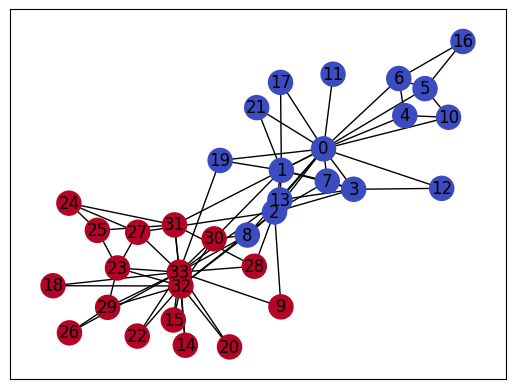

In [4]:
nx.draw_networkx(G=G, 
                 node_color=labels,
                    cmap='coolwarm',
                    with_labels=True,
)

In [5]:
# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(800):
        walks.append(random_walk(G, node, 10))

# Print the first random walk
print(walks[0])

['0', '6', '4', '10', '4', '6', '5', '0', '31', '32', '29']


In [6]:
from gensim.models.word2vec import Word2Vec


# Create Word2Vec
model = Word2Vec(walks,
                 hs=1,   # Hierarchical softmax
                 sg=1,   # Skip-gram
                 vector_size=100,
                 window=10,
                 workers=1,
                 seed=1)

print(f'Shape of embedding matrix: {model.wv.vectors.shape}')

# Build vocabulary
model.build_vocab(walks)

# Train model
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

Shape of embedding matrix: (34, 100)


(1872332, 8976000)

In [7]:
# Most similar nodes
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
    print(f'   {similarity}')

# Similarity between two nodes
print(f"\nSimilarity between node 0 and 4: {model.wv.similarity('0', '4')}")

Nodes that are the most similar to node 0:
   ('4', 0.6763075590133667)
   ('10', 0.6594610810279846)
   ('5', 0.6259195804595947)
   ('6', 0.6182330846786499)
   ('16', 0.5533576607704163)
   ('21', 0.5410023331642151)
   ('17', 0.5356372594833374)
   ('7', 0.5327117443084717)
   ('1', 0.5136660933494568)
   ('11', 0.4921998977661133)

Similarity between node 0 and 4: 0.6763076186180115


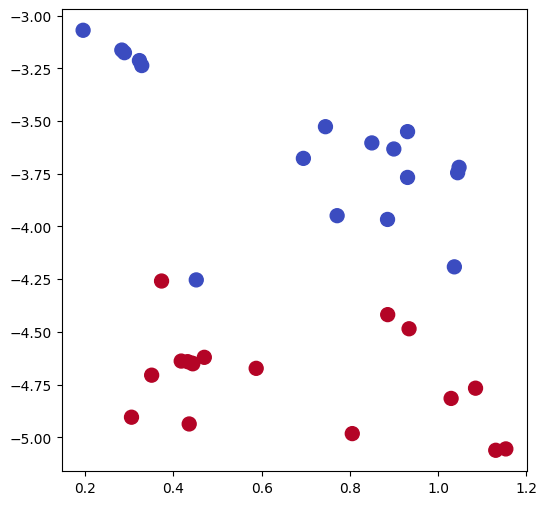

In [8]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# Preprocess word vectors and label
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

# Train TSNE
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

# Plot TSNE
plt.figure(figsize=(6, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]

# Train classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(nodes_wv[train_mask], labels[train_mask])

# Evaluate accuracy
y_pred = clf.predict(nodes_wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Accuracy = {acc*100:.2f}%')

Accuracy = 90.91%
